# Assignment 3 - MNIST [digit prediction with numpy]

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import warnings
import torch

### Utils Function

First, we will normlize the data for better model convergence

In [2]:
def normlize_image(X):
    return ((X / 255.) - .5) * 2

Now, We'll Create activation function and one hot encoder for comparasion reasons

In [3]:
#suppress warnings
warnings.filterwarnings('ignore')

In [4]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

In [5]:
def softmax(x):
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

In [6]:
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

Mini Generator can be created with torch, However to be True for the cuase we'll create data loader using python generators

In [7]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

Metrics Function 

In [8]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

In [9]:
def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

Wrapper Function for easy access and more abstract code 

In [10]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=200):
    mse, correct_pred, auc_sum, num_examples , auc_counter = 0., 0, 0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        if issubclass(type(nnet),torch.nn.Module):
            features = torch.from_numpy(features).float()
            probas = nnet(features).detach().numpy()
        else: 
            _,_, probas = nnet.forward(features)
        probas = softmax(probas)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum() 
        try:
            auc_sum += roc_auc_score(targets, probas, average='macro',multi_class='ovo')
            auc_counter += 1
        except ValueError:
            print("----")
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    auc = auc_sum / auc_counter
    return mse, acc, auc

### Fetch Digit Data

In [11]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# change to np type
X = X.values
y = y.astype(int).values

### Split Data 

In [12]:
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
# del X,y

## Models

### single-Layer (numpy)

This code was implmented by rasbt in his book <a href="https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb" target="_blank">"machine-learning-book"</a>

In [13]:
class OneLayerNumpy:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return None, a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

### Two Layer ANN (numpy)

After understanding the effect, we'll improve the model by adding new hidden layer as followed:

In [14]:
class TwoLayerNumpy:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        self.weight_hh = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_hh = np.zeros(num_hidden)
        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # First Layer 
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        act_h = sigmoid(z_h)
        # Second Layer 
        z_hh = np.dot(act_h, self.weight_hh.T) + self.bias_hh
        act_hh = sigmoid(z_hh)
        z_out = np.dot(act_hh, self.weight_out.T) + self.bias_out
        act_out = sigmoid(z_out)
        return act_h, act_hh, act_out

    def update(self, grad, lr):
        self.weight_h -= lr * grad[0]
        self.bias_h -= lr * grad[1]
        
        self.weight_hh -= lr * grad[2]
        self.bias_hh -= lr * grad[3]
        
        self.weight_out -= lr * grad[4]
        self.bias_out -= lr * grad[5]
    
    
    def backward(self, x, act_h, act_hh, act_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # dLoss/dWeightsOut = dLoss/dActOut * dActOut/dZOut * dZOut/dWOut
        dLoss_dActOut =  2.*(act_out - y_onehot) / y.shape[0]
        dActOut_dZOut =  act_out * (1. - act_out)
        # dloss/dzout
        dLoss_dZOut = dLoss_dActOut * dActOut_dZOut
        dZOut_dWOut = act_hh
        # Lets Multiply
        dLoss_dWOut = np.dot(dLoss_dZOut.T,dZOut_dWOut)
        dLoss_dBOut = np.sum(dLoss_dZOut, axis=0)
        
        #########################
        ### Middle layer weights
        #########################
        # dLoss/dWeightsHH = dLoss/dZOut * dZOut/dActHH * dActHH/dZHH * dZHH/dWHH
        dZOut_dActHH = self.weight_out
        dLoss_dActHH = np.dot(dLoss_dZOut,dZOut_dActHH)
        dActHH_dZHH =  act_hh * (1. - act_hh)
        dZHH_dWHH = act_h
        dLoss_dZHH = dLoss_dActHH * dActHH_dZHH
        # Lets Multiply
        dLoss_dWeightsHH = np.dot(dLoss_dZHH.T,dZHH_dWHH)
        dLoss_dBHH = np.sum(dLoss_dZHH, axis=0)
        

        #########################
        ### First layer weights
        #########################
        # dLoss/dWeightsH = dLoss/dZOHH * dZHH/dActH * dActH/dZH * dZH/dWH
        dZHH_dActH = self.weight_hh
        dLoss_dActH = np.dot(dLoss_dZHH,dZHH_dActH)
        dActH_dZH =  act_h * (1. - act_h)
        dZH_dWH = x
        dLoss_dZH = dLoss_dActH * dActH_dZH
        # Lets Multiply
        dLoss_dWeightsH = np.dot(dLoss_dZH.T,dZH_dWH)
        dLoss_dBH = np.sum(dLoss_dZH, axis=0)
        
        return (dLoss_dWeightsH, dLoss_dBH, dLoss_dWeightsHH, dLoss_dBHH, dLoss_dWOut ,dLoss_dBOut)

### single-Layer (torch)

We'll use Pytorch framework for comparasion reasion, and see how easly we created the model

In [15]:
class TorchModel(torch.nn.Module):
    def __init__(self,num_features, num_hidden, num_classes):
        super(TorchModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features,num_hidden),
            nn.Sigmoid(),
            nn.Linear(num_hidden,num_classes),
        )

    def forward(self, x):
        return self.net(x)

### Create Model Instance

In [16]:
param = {"num_features":28*28,"num_hidden":50,"num_classes":10}
th_model = TorchModel(**param)
np_model_1 = OneLayerNumpy(**param)
np_model_2 = TwoLayerNumpy(**param)
models = [th_model,np_model_1,np_model_2]

In [17]:
optimizer = torch.optim.SGD(th_model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.MSELoss() 

## Train Models

In [18]:
def train(models, X_train, y_train, num_epochs = 50,minibatch_size=100, learning_rate=0.1):
    np_1_info = {'loss': [], 'acc': [], 'auc': []}
    np_2_info = {'loss': [], 'acc': [], 'auc': []}
    th_info = {'loss': [], 'acc': [], 'auc': []}
    th_model, np_model_1 , np_model_2 = models    
    for e in range(num_epochs):
        print("="*10,f"Epoch N.{e}","="*10)
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        th_model.train()
        for X_train_mini, y_train_mini in minibatch_gen:
            inputs = torch.from_numpy(X_train_mini).float()
            labels = torch.from_numpy(int_to_onehot(y_train_mini, num_labels=10)).float()
            optimizer.zero_grad()
            ### Foward ###
            _, np_1_a_h, np_1_a_out = np_model_1.forward(X_train_mini)
            np_2_act_h, np_2_act_hh, np_2_act_out = np_model_2.forward(X_train_mini)
            preds = th_model(inputs)
            ### Backward ### 
            gradient = np_model_2.backward(X_train_mini,np_2_act_h,np_2_act_hh,np_2_act_out,y_train_mini)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = np_model_1.backward(X_train_mini, np_1_a_h, np_1_a_out, y_train_mini)
            loss = criterion(preds, labels)
            loss.backward()
            ### Update Weights
            np_model_2.update(gradient,learning_rate)
            np_model_1.weight_h -= learning_rate * d_loss__d_w_h
            np_model_1.bias_h -= learning_rate * d_loss__d_b_h
            np_model_1.weight_out -= learning_rate * d_loss__d_w_out
            np_model_1.bias_out -= learning_rate * d_loss__d_b_out
            optimizer.step()
        def helper(dct, model):
            x,y,z = compute_mse_and_acc(model, X_train, y_train)
            dct['loss'].append(x)
            dct['acc'].append(y*100)
            dct['auc'].append(z*100)
        helper(np_1_info,np_model_1)
        helper(np_2_info,np_model_2)
        helper(th_info,th_model)
        print( 
              f"| np_1 MSE: {np_1_info['loss'][-1]:.2f} "
              f"| np_1 Acc: {np_1_info['acc'][-1]:.2f}% "
              f"| np_1 Auc: {np_1_info['auc'][-1]:.2f}% "
              f"| np_2 MSE: {np_2_info['loss'][-1]:.2f} "
              f"| np_2 Acc: {np_2_info['acc'][-1]:.2f}%"
              f"| np_2 Auc: {np_2_info['auc'][-1]:.2f}%"
              f"| th MSE: {th_info['loss'][-1]:.2f} "
              f"| th Acc: {th_info['acc'][-1]:.2f}%"
              f"| th Auc: {th_info['auc'][-1]:.2f}%"
        )
    return th_info, np_1_info, np_2_info

In [19]:
#x_train, X_test, y_train, y_test
th_info, np_1_info, np_2_info = train(models,x_train,y_train)

========== Epoch N.0 ==========
| np_1 MSE: 0.08 | np_1 Acc: 79.39% | np_1 Auc: 96.64% | np_2 MSE: 0.09 | np_2 Acc: 29.64%| np_2 Auc: 87.06%| th MSE: 0.08 | th Acc: 86.78%| th Auc: 97.91%
========== Epoch N.1 ==========
| np_1 MSE: 0.08 | np_1 Acc: 84.79% | np_1 Auc: 97.86% | np_2 MSE: 0.09 | np_2 Acc: 49.23%| np_2 Auc: 92.31%| th MSE: 0.07 | th Acc: 88.80%| th Auc: 98.49%
========== Epoch N.2 ==========
| np_1 MSE: 0.08 | np_1 Acc: 86.28% | np_1 Auc: 98.29% | np_2 MSE: 0.08 | np_2 Acc: 65.20%| np_2 Auc: 95.18%| th MSE: 0.07 | th Acc: 89.63%| th Auc: 98.69%
========== Epoch N.3 ==========
| np_1 MSE: 0.07 | np_1 Acc: 88.40% | np_1 Auc: 98.65% | np_2 MSE: 0.08 | np_2 Acc: 76.07%| np_2 Auc: 96.43%| th MSE: 0.07 | th Acc: 89.77%| th Auc: 98.81%
========== Epoch N.4 ==========
| np_1 MSE: 0.07 | np_1 Acc: 89.10% | np_1 Auc: 98.78% | np_2 MSE: 0.08 | np_2 Acc: 82.70%| np_2 Auc: 97.52%| th MSE: 0.07 | th Acc: 90.40%| th Auc: 98.93%
========== Epoch N.5 ==========
| np_1 MSE: 0.07 | np_1 Acc:

## Evaluating the neural network performance

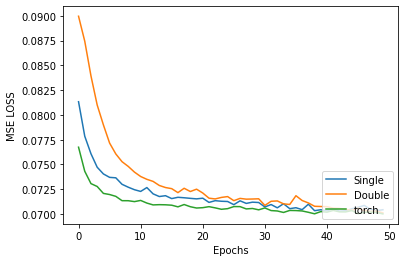

In [29]:
plt.plot(range(len(np_1_info['loss'])), np_1_info['loss'], label='Single')
plt.plot(range(len( np_2_info['loss'])), np_2_info['loss'], label='Double')
plt.plot(range(len(th_info['loss'])), th_info['loss'], label='torch')

plt.ylabel('MSE LOSS')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

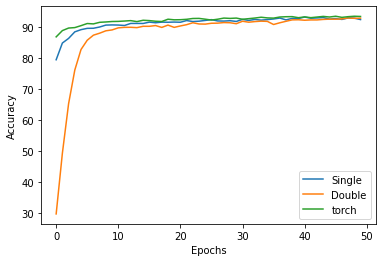

In [30]:
plt.plot(range(len(np_1_info['acc'])), np_1_info['acc'], label='Single')
plt.plot(range(len( np_2_info['acc'])), np_2_info['acc'], label='Double')
plt.plot(range(len(th_info['acc'])), th_info['acc'], label='torch')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

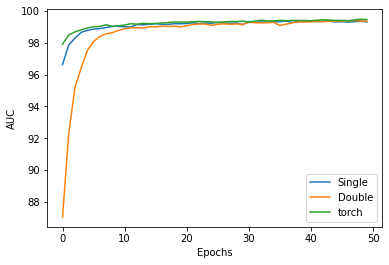

In [31]:
plt.plot(range(len(np_1_info['auc'])), np_1_info['auc'], label='Single')
plt.plot(range(len( np_2_info['auc'])), np_2_info['auc'], label='Double')
plt.plot(range(len(th_info['auc'])), th_info['auc'], label='torch')

plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()